In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
import os
import statistics

In [3]:

def extract_tight_text_lines(image_path, preprocessed_image=None, output_dir=None, 
                            adaptive_segmentation=True, peak_prominence=10):
    """
    Extract text lines from an image with very tight line spacing where characters may overlap.
    
    Parameters:
    -----------
    image_path : str
        Path to the original image
    preprocessed_image : numpy.ndarray, optional
        Already preprocessed binary image
    output_dir : str, optional
        Directory to save extracted lines
    adaptive_segmentation : bool
        Whether to use adaptive segmentation for variable line spacing
    peak_prominence : int
        Prominence parameter for peak detection, controls sensitivity
        
    Returns:
    --------
    tuple
        (list of line images, visualization image, line regions)
    """
    # Load and preprocess image if needed
    if preprocessed_image is None:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")
            
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Otsu's thresholding after sharpening
        kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(gray, -1, kernel_sharpen)
        _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        binary = preprocessed_image.copy()
        # Ensure binary has proper format
        if len(binary.shape) > 2:
            binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
        # Make sure text is white (255) and background is black (0)
        if np.mean(binary) < 127:
            binary = cv2.bitwise_not(binary)
    
    # Create a copy of the original image for visualization
    if image_path and os.path.exists(image_path):
        original = cv2.imread(image_path)
        visualization = original.copy() if original is not None else np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)
    else:
        if len(binary.shape) == 2:
            visualization = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        else:
            visualization = binary.copy()
    
    # Calculate horizontal projection profile (sum of pixel values for each row)
    h_proj = np.sum(binary, axis=1)
    
    # Enhanced preprocessing for tightly spaced lines
    # 1. Apply more sophisticated smoothing using Savitzky-Golay filter
    window_size = min(21, len(h_proj) // 5 * 2 + 1)  # Must be odd
    window_size = max(5, window_size)  # At least 5
    
    try:
        h_proj_smooth = savgol_filter(h_proj, window_size, 3)  # Polynomial order 3
    except:
        # Fallback to simpler smoothing if Savitzky-Golay fails
        h_proj_smooth = np.convolve(h_proj, np.ones(5)/5, mode='same')
    
    # 2. Enhance valleys between lines to improve separation
    # Calculate the first derivative to find rapid changes
    gradient = np.gradient(h_proj_smooth)
    
    # Create an enhanced profile with deeper valleys
    enhanced_profile = h_proj_smooth.copy()
    
    # Line detection strategy depends on text density
    if adaptive_segmentation:
        # For very tight text with overlapping characters:
        # Find local minima in the projection profile
        minima_indices = []
        for i in range(1, len(enhanced_profile) - 1):
            if enhanced_profile[i] < enhanced_profile[i-1] and enhanced_profile[i] < enhanced_profile[i+1]:
                minima_indices.append(i)
        
        # Filter minima to keep only significant ones
        if len(minima_indices) > 0:
            minima_values = [enhanced_profile[i] for i in minima_indices]
            median_value = np.median(minima_values)
            significant_minima = [i for i, val in zip(minima_indices, minima_values) 
                                if val < median_value * 1.5]  # Adjust threshold as needed
            
            valleys = np.array(significant_minima)
        else:
            valleys = np.array([])
        
        # Add image boundaries if needed
        if len(valleys) == 0 or valleys[0] > 10:
            valleys = np.insert(valleys, 0, 0)
        if len(valleys) == 0 or valleys[-1] < binary.shape[0] - 10:
            valleys = np.append(valleys, binary.shape[0])
    else:
        # Traditional approach using peak detection
        # Find valleys (local minima)
        inv_proj = np.max(enhanced_profile) - enhanced_profile
        valleys, _ = find_peaks(inv_proj, prominence=peak_prominence)
        
        # Make sure we start and end with valleys for proper line extraction
        if len(valleys) > 0:
            if valleys[0] > 10:
                valleys = np.insert(valleys, 0, 0)
            if valleys[-1] < binary.shape[0] - 10:
                valleys = np.append(valleys, binary.shape[0])
        else:
            valleys = np.array([0, binary.shape[0]])
    
    # Extract line regions
    line_regions = []
    for i in range(len(valleys) - 1):
        start_y = valleys[i]
        end_y = valleys[i+1]
        
        # Extract the line image
        line_img = binary[start_y:end_y, :]
        
        # Only add if there's substantial content
        if np.sum(line_img) > line_img.size * 0.01:  # At least 1% of pixels should be text
            line_regions.append((start_y, end_y, line_img))
    
    # Draw line boundaries on visualization image
    for start_y, end_y, _ in line_regions:
        cv2.line(visualization, (0, start_y), (visualization.shape[1], start_y), (0, 255, 0), 2)
        cv2.line(visualization, (0, end_y), (visualization.shape[1], end_y), (0, 0, 255), 2)
    
    # Extract line images
    line_images = [line_img for _, _, line_img in line_regions]
    
    # Save extracted lines if output directory provided
    if output_dir and line_images:
        os.makedirs(output_dir, exist_ok=True)
        for i, line_img in enumerate(line_images):
            line_path = os.path.join(output_dir, f"line_{i+1}.png")
            cv2.imwrite(line_path, line_img)
            print(f"Saved line {i+1} to {line_path}")
    
    return line_images, visualization, line_regions

def analyze_line_spacing(binary_image):
    """
    Analyze the spacing between text lines to determine optimal parameters.
    
    Parameters:
    -----------
    binary_image : numpy.ndarray
        Binary image with text
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    # Calculate horizontal projection profile
    h_proj = np.sum(binary_image, axis=1)
    
    # Smooth the profile
    window_size = min(21, len(h_proj) // 5 * 2 + 1)  # Must be odd
    window_size = max(5, window_size)  # At least 5
    
    try:
        h_proj_smooth = savgol_filter(h_proj, window_size, 3)
    except:
        h_proj_smooth = np.convolve(h_proj, np.ones(5)/5, mode='same')
    
    # Find peaks (text lines) and valleys (spaces between lines)
    peaks, peak_props = find_peaks(h_proj_smooth, distance=5)
    valleys, valley_props = find_peaks(-h_proj_smooth, distance=5)
    
    # Calculate distances between adjacent lines
    line_distances = []
    if len(peaks) > 1:
        for i in range(len(peaks) - 1):
            line_distances.append(peaks[i+1] - peaks[i])
    
    # Calculate average line height using the projection profile
    line_heights = []
    if len(valleys) > 1:
        for i in range(len(valleys) - 1):
            # Find peaks between valleys
            line_peaks = [p for p in peaks if valleys[i] < p < valleys[i+1]]
            if len(line_peaks) > 0:
                max_value = max([h_proj_smooth[p] for p in line_peaks])
                # Estimate line height using FWHM (Full Width at Half Maximum)
                half_max = max_value / 2
                above_half_max = h_proj_smooth[valleys[i]:valleys[i+1]] > half_max
                if np.any(above_half_max):
                    line_heights.append(np.sum(above_half_max))
    
    # Calculate statistics
    avg_line_distance = np.mean(line_distances) if line_distances else 0
    avg_line_height = np.mean(line_heights) if line_heights else 0
    
    # Determine if lines are tightly spaced
    tight_spacing = avg_line_distance <= avg_line_height * 1.2 if avg_line_height > 0 else True
    
    # Create visualization
    vis_height = len(h_proj)
    vis_width = max(h_proj_smooth) * 1.2
    visualization = np.zeros((vis_height, int(vis_width)), dtype=np.uint8)
    
    # Draw projection profile
    for i, val in enumerate(h_proj_smooth):
        cv2.line(visualization, (0, i), (int(val), i), 255, 1)
    
    # Mark peaks and valleys
    for peak in peaks:
        cv2.circle(visualization, (int(h_proj_smooth[peak]), peak), 3, 127, -1)
    
    for valley in valleys:
        cv2.circle(visualization, (int(h_proj_smooth[valley]), valley), 3, 80, -1)
    
    return {
        "avg_line_distance": avg_line_distance,
        "avg_line_height": avg_line_height,
        "tight_spacing": tight_spacing,
        "num_lines_detected": len(peaks),
        "visualization": visualization
    }

def display_analysis_results(binary_image, analysis_results):
    """
    Display the results of text line spacing analysis.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Display binary image
    axes[0].imshow(binary_image, cmap='gray')
    axes[0].set_title("Binary Image")
    axes[0].axis('off')
    
    # Display projection profile analysis
    axes[1].imshow(analysis_results["visualization"], cmap='gray')
    axes[1].set_title(f"Line Spacing Analysis\n"
                     f"Avg Line Distance: {analysis_results['avg_line_distance']:.2f} px\n"
                     f"Avg Line Height: {analysis_results['avg_line_height']:.2f} px\n"
                     f"Lines Detected: {analysis_results['num_lines_detected']}\n"
                     f"Tight Spacing: {'Yes' if analysis_results['tight_spacing'] else 'No'}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def try_different_methods(image_path, preprocessed_image=None):
    """
    Try different line extraction methods and display results for comparison.
    
    Parameters:
    -----------
    image_path : str
        Path to the original image
    preprocessed_image : numpy.ndarray, optional
        Already preprocessed binary image
    """
    # Load and preprocess image if needed
    if preprocessed_image is None:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")
            
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Otsu's thresholding after sharpening
        kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(gray, -1, kernel_sharpen)
        _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        binary = preprocessed_image.copy()
        if len(binary.shape) > 2:
            binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
        if np.mean(binary) < 127:
            binary = cv2.bitwise_not(binary)
    
    # Analyze line spacing
    analysis = analyze_line_spacing(binary)
    display_analysis_results(binary, analysis)
    
    # Try different methods based on analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Method 1: Standard approach
    lines1, vis1, _ = extract_tight_text_lines(image_path, binary, 
                                              adaptive_segmentation=False, 
                                              peak_prominence=10)
    axes[0].imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Standard Method\nDetected {len(lines1)} lines")
    axes[0].axis('off')
    
    # Method 2: More sensitive
    lines2, vis2, _ = extract_tight_text_lines(image_path, binary, 
                                              adaptive_segmentation=False, 
                                              peak_prominence=5)
    axes[1].imshow(cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"More Sensitive\nDetected {len(lines2)} lines")
    axes[1].axis('off')
    
    # Method 3: Adaptive segmentation for tight spacing
    lines3, vis3, _ = extract_tight_text_lines(image_path, binary, 
                                              adaptive_segmentation=True)
    axes[2].imshow(cv2.cvtColor(vis3, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Adaptive Method\nDetected {len(lines3)} lines")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "standard": lines1,
        "sensitive": lines2,
        "adaptive": lines3
    }

def watershed_line_separation(binary_image):
    """
    Use watershed algorithm to separate touching text lines.
    
    Parameters:
    -----------
    binary_image : numpy.ndarray
        Binary image with text
        
    Returns:
    --------
    numpy.ndarray
        Image with separated text lines
    """
    # Create a distance transform
    dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
    
    # Normalize the distance image for range 0-255
    cv2.normalize(dist_transform, dist_transform, 0, 255, cv2.NORM_MINMAX)
    dist_transform = dist_transform.astype(np.uint8)
    
    # Threshold to get potential line centers
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    
    # Find unknown region
    sure_bg = cv2.dilate(binary_image, np.ones((3,3), np.uint8), iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that background is not 0, but 1
    markers = markers + 1
    
    # Mark the unknown region with zero
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR), markers)
    
    # Create a visualization image
    visualization = np.zeros_like(binary_image)
    for i in range(2, markers.max() + 1):
        # Extract each watershed region
        mask = np.uint8(markers == i) * 255
        visualization = cv2.bitwise_or(visualization, mask)
    
    return visualization, markers

def morphological_line_separation(binary_image):
    """
    Use morphological operations to separate touching text lines.
    
    Parameters:
    -----------
    binary_image : numpy.ndarray
        Binary image with text
        
    Returns:
    --------
    numpy.ndarray
        Image with separated text lines
    """
    # Create copy of the image
    processed = binary_image.copy()
    
    # Apply horizontal closing to connect characters in the same line
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    processed = cv2.morphologyEx(processed, cv2.MORPH_CLOSE, horizontal_kernel)
    
    # Apply vertical opening to separate text lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, vertical_kernel)
    
    # Apply horizontal dilation to reconnect characters
    processed = cv2.dilate(processed, horizontal_kernel, iterations=1)
    
    # Label connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed, 4)
    
    # Create a visualization image
    visualization = np.zeros_like(binary_image)
    
    # Process each connected component
    for i in range(1, num_labels):  # Skipping background label 0
        mask = (labels == i).astype(np.uint8) * 255
        
        # Get the original text pixels within this connected component
        component_text = cv2.bitwise_and(binary_image, binary_image, mask=mask)
        
        # Add to visualization
        visualization = cv2.bitwise_or(visualization, component_text)
    
    return visualization, labels

def interactive_line_extraction(image_path, preprocessed_image=None):
    """
    Interactive version that shows different line extraction techniques for tightly spaced text.
    
    Parameters:
    -----------
    image_path : str
        Path to the original image
    preprocessed_image : numpy.ndarray, optional
        Already preprocessed binary image
    """
    # Load and preprocess image if needed
    if preprocessed_image is None:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")
            
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Otsu's thresholding after sharpening
        kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(gray, -1, kernel_sharpen)
        _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        binary = preprocessed_image.copy()
        if len(binary.shape) > 2:
            binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
        if np.mean(binary) < 127:
            binary = cv2.bitwise_not(binary)
    
    # Try different advanced techniques
    # 1. Standard line extraction
    lines1, vis1, _ = extract_tight_text_lines(image_path, binary, 
                                              adaptive_segmentation=True)
    
    # 2. Watershed-based separation
    watershed_result, watershed_markers = watershed_line_separation(binary)
    
    # 3. Morphological separation
    morphological_result, morphological_labels = morphological_line_separation(binary)
    
    # Display results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original binary image
    axes[0, 0].imshow(binary, cmap='gray')
    axes[0, 0].set_title("Binary Image")
    axes[0, 0].axis('off')
    
    # Standard method
    axes[0, 1].imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f"Projection Profile Method\nDetected {len(lines1)} lines")
    axes[0, 1].axis('off')
    
    # Watershed result
    axes[1, 0].imshow(watershed_result, cmap='gray')
    axes[1, 0].set_title(f"Watershed Separation\nDetected {watershed_markers.max()-1} regions")
    axes[1, 0].axis('off')
    
    # Morphological result
    axes[1, 1].imshow(morphological_result, cmap='gray')
    axes[1, 1].set_title(f"Morphological Separation\nDetected {morphological_labels.max()} components")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "projection_lines": lines1,
        "watershed_result": watershed_result,
        "morphological_result": morphological_result
    }



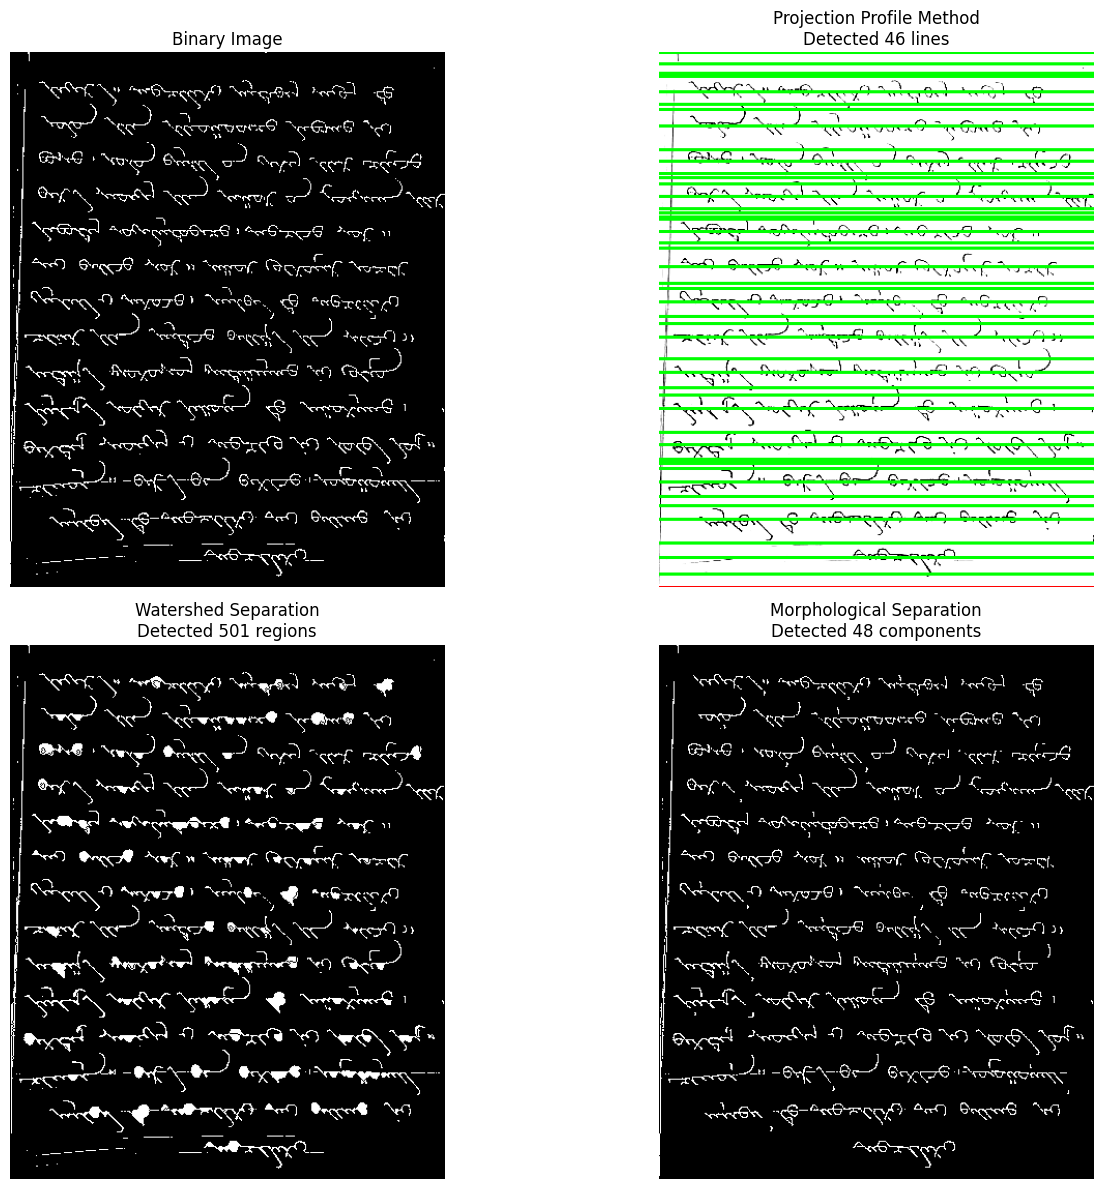

In [4]:
image_path = "data/test-hori.png"
output_dir = "extracted_text"

results = interactive_line_extraction(image_path)
    


In [13]:
def display(img, title="Image", cmap=None, figsize=(10, 10)):
    """Displays an image using matplotlib."""
    plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # Convert BGR (OpenCV default) to RGB for matplotlib
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray') # Keep grayscale if it's already gray
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_boxes(image, boxes, color=(0, 255, 0), thickness=2):
    """Draws bounding boxes on a copy of the image."""
    output_image = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), color, thickness)
    return output_image
 
def line_segmentation(orig_img, dilate_kernel_x=3, dilate_kernel_y=30, aspect_ratio=0.25, median_width_threshold=0.7):
    """Line segmentation."""
    lines = []

    img = orig_img
    if img.mean() < 100:
        # black background? then invert
        img = (255 - img)

    # threshold and dilate
    _, threshed_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((dilate_kernel_y, dilate_kernel_x), np.uint8)
    dilated_img = cv2.dilate(threshed_img, kernel, iterations=1)

    # compute and sort contours
    img_height, img_width = img.shape[:2]
    contours_result = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours_result[len(contours_result)-2]
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # compute median contour width
    widths = []
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if aspect_ratio * h >= w:
            # Mongolian script is written vertically so height must be bigger than width
            widths.append(w)
    # filter out contours by width
    median_width = statistics.median(widths)
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if aspect_ratio * h >= w and (median_width * (1 - median_width_threshold) <= w <= median_width * (1 + median_width_threshold)):
            lines.append([(x, y), (x+w, y+h)])
    return lines

In [13]:
image = cv2.imread("data/test_printed.png", 0)
lines = line_segmentation(image)
len(lines)

6

In [4]:
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# List of boundaries (top-left and bottom-right)
boundaries = lines

for top_left, bottom_right in boundaries:
    cv2.rectangle(image_color, top_left, bottom_right, (0, 0, 255), 1)

# Convert BGR to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)

# Show image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Boundaries")
plt.show()

NameError: name 'image' is not defined

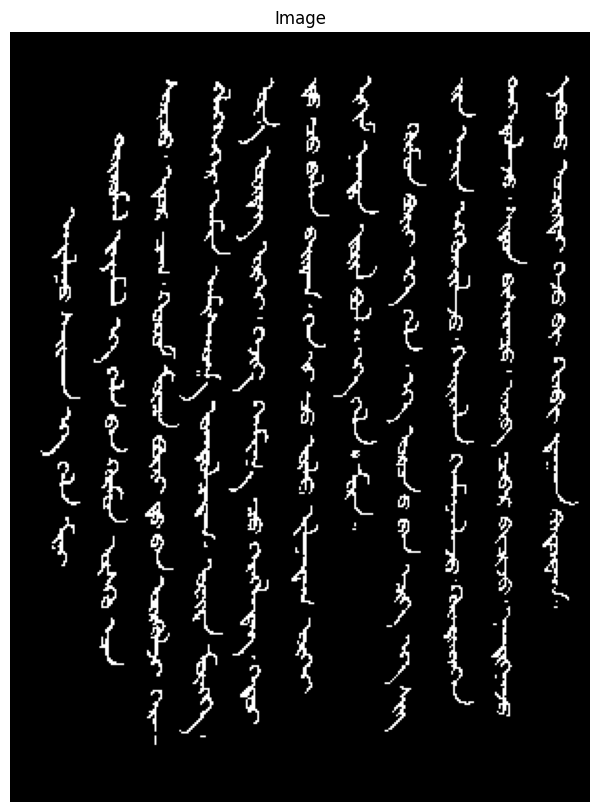

In [21]:
IMAGE_PATH = 'data/test2.png'
img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For displaying original later
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Binarization (Otsu should still work well)
# Text white (255), background black (0)
thresh_val, binary_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display(binary_img)

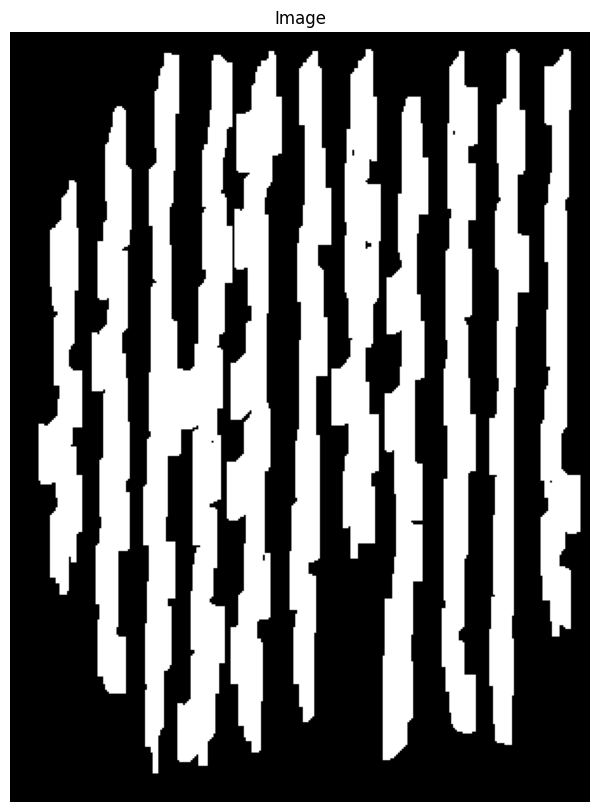

In [22]:
kernel = np.ones((30, 3), np.uint8)
dilated_img = cv2.dilate(binary_img, kernel, iterations=1)
display(dilated_img)

In [25]:
dilated_img = binary_img
contours_result = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours_result[len(contours_result)-2]
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# compute median contour width
arr = []
for contour in sorted_contours:
    x, y, w, h = cv2.boundingRect(contour)
    arr.append([x, y, w, h])

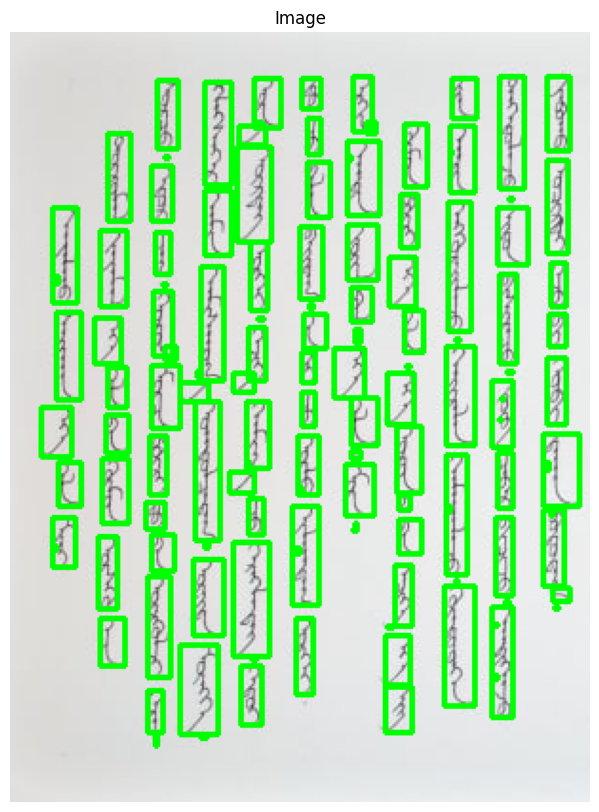

In [28]:
out = draw_boxes(img, arr)
display(out)